## 任务2 数据清洗

## 缺失值分析及处理

* 缺失值出现的原因分析
* 采取合适的方式对缺失值进行填充

## 异常值分析及处理

* 根据测试集数据的分布处理训练集的数据分布

* 使用合适的方法找出异常值
* 对异常值进行处理

## 深度清洗

* 分析每一个communityName、city、region、plate的数据分布并对其进行数据清洗




In [157]:
#导包 读数据
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import time

from sklearn.preprocessing import OneHotEncoder,MinMaxScaler,LabelEncoder
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.ensemble import IsolationForest

train_data = pd.read_csv('./train_data.csv')  #训练集
test_a = pd.read_csv('./test_a.csv')       #测试集A
all_data = pd.concat([train_data, test_a], ignore_index=True) #合并数据集
# train_data.head(5)
# test_a.head(5)
all_data.head(10)

,ID,area,bankNum,buildYear,busStationNum,city,communityName,drugStoreNum,gymNum,hospitalNum,...,totalWorkers,tradeLandArea,tradeLandNum,tradeMeanPrice,tradeMoney,tradeNewMeanPrice,tradeNewNum,tradeSecNum,tradeTime,uv
0,100309852,68.06,16,1953,36,SH,XQ00051,12,15,1,...,28248,0.0,0,47974.22551,2000.0,104573.48460,25,111,2018/11/28,284.0
1,100307942,125.55,16,2007,184,SH,XQ00130,27,5,1,...,14823,0.0,0,40706.66775,2000.0,33807.53497,2,2,2018/12/16,22.0
2,100307764,132.00,37,暂无信息,60,SH,XQ00179,24,35,3,...,77645,0.0,0,34384.35089,16000.0,109734.16040,11,555,2018/12/22,20.0
3,100306518,57.00,47,暂无信息,364,SH,XQ00313,83,30,8,...,8750,108037.8,1,20529.55050,1600.0,30587.07058,58,260,2018/12/21,279.0
4,100305262,129.00,10,暂无信息,141,SH,XQ01257,21,5,0,...,800,0.0,0,24386.36577,2900.0,51127.32846,34,38,2018/11/18,480.0
5,100304268,223.35,95,2003,276,SH,XQ00457,118,64,14,...,48204,0.0,0,41847.05870,14000.0,82388.42970,146,276,2018/11/14,1304.0
6,100304055,78.94,47,2014,364,SH,XQ00246,83,30,8,...,8750,0.0,0,20106.77761,1000.0,29691.24733,46,216,2018/11/18,469.0
7,100295123,76.00,86,1997,461,SH,XQ02331,106,36,6,...,28546,0.0,0,22759.44425,1800.0,35584.24959,389,481,2018/3/24,2942.0
8,100293141,120.55,86,2007,461,SH,XQ02346,106,36,6,...,28546,0.0,0,22759.44425,1450.0,35584.24959,389,481,2018/3/19,2942.0
9,100293063,83.00,86,1993,461,SH,XQ02310,106,36,6,...,28546,0.0,0,21067.22902,1700.0,33797.35915,119,331,2018/4/26,3035.0


## 一、缺失值处理



## 主要思路分析
虽然这步骤是缺失值处理，但还会涉及到一些最最基础的数据处理。  
1. **缺失值处理**  
缺失值的处理手段大体可以分为：删除、填充、映射到高维(当做类别处理)。  
详细的请自行查找相关资料学习。  
根据任务一，直接找到的缺失值情况是pu和pv；但是，根据特征nunique分布的分析，可以发现rentType存在"--"的情况，这也算是一种缺失值。  
此外，诸如rentType的"未知方式"；houseToward的"暂无数据"等，本质上也算是一种缺失值，但是对于这些缺失方式，我们可以把它当做是特殊的一类处理，而不需要去主动修改或填充值。  
  
  将rentType的"--"转换成"未知方式"类别；  
  pv/pu的缺失值用均值填充；  
  buildYear存在"暂无信息"，将其用众数填充。  
  
    
2. **转换object类型数据**  
这里直接采用LabelEncoder的方式编码。  
  
  
3. **时间字段的处理**  
buildYear由于存在"暂无信息",所以需要主动将其转换int类型；  
tradeTime，将其分割成月和日。  
  
  
4. **删除无关字段**  
ID是唯一码，建模无用，所以直接删除；  
city只有一个SH值，也直接删除；  
tradeTime已经分割成月和日，删除原来字段

In [158]:
def preprcessingData(data):
    #填充缺失值
    data['rentType'][data['rentType'] == '__'] = '未知方式'
    
    #转换object类型的数据
    columns = ['rentType','communityName','houseType', 'houseFloor', 'houseToward', 'houseDecoration', 'plate']
    
    for fea in columns:
        data[fea] = LabelEncoder().fit_transform(data[fea])
        
    #将buildYear列转换为整型数据
    buildYearmean = pd.DataFrame(data[data['buildYear'] != '暂无信息']['buildYear'].mode())
    data.loc[data[data['buildYear'] == '暂无信息'].index, 'buildYear'] = buildYearmean.iloc[0, 0]
    data['buildYear'] = data['buildYear'].astype('int')
    
    #处理pv 和 uv 的空值，使用均值填充
    data['pv'].fillna(data['pv'].mean(), inplace = True)
    data['uv'].fillna(data['uv'].mean(), inplace = True)
    data['pv'] = data['pv'].astype('int')
    data['uv'] = data['uv'].astype('int')
    
    #分割交易时间
    def month(x):
        month = int(x.split('/')[1])
        return month

    def day(x):
        day = int(x.split('/')[2])
        return day
    
    data['month'] = data['tradeTime'].apply(lambda x: month(x))
    data['day'] = data['tradeTime'].apply(lambda x: day(x))
    
    #去掉部分特征
    data.drop('city', axis = 1, inplace = True)
    data.drop('tradeTime', axis = 1, inplace = True)
    data.drop('ID', axis = 1, inplace = True)
    return data

train_data = preprcessingData(train_data)
train_data.info()
train_data.head(10)
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41440 entries, 0 to 41439
Data columns (total 50 columns):
area                  41440 non-null float64
rentType              41440 non-null int32
houseType             41440 non-null int32
houseFloor            41440 non-null int32
totalFloor            41440 non-null int64
houseToward           41440 non-null int32
houseDecoration       41440 non-null int32
communityName         41440 non-null int32
region                41440 non-null object
plate                 41440 non-null int32
buildYear             41440 non-null int32
saleSecHouseNum       41440 non-null int64
subwayStationNum      41440 non-null int64
busStationNum         41440 non-null int64
interSchoolNum        41440 non-null int64
schoolNum             41440 non-null int64
privateSchoolNum      41440 non-null int64
hospitalNum           41440 non-null int64
drugStoreNum          41440 non-null int64
gymNum                41440 non-null int64
bankNum               41440 

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,region,plate,...,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeMoney,month,day
0,68.06,3,12,1,16,6,0,50,RG00001,63,...,0.0000,28248,614,111546,1124,284,0,2000.0,11,28
1,125.55,3,28,0,14,6,2,129,RG00002,48,...,0.0000,14823,148,157552,701,22,1,2000.0,12,16
2,132.00,3,28,1,32,6,0,178,RG00002,49,...,0.0000,77645,520,131744,57,20,1,16000.0,12,22
3,57.00,3,4,0,17,6,3,312,RG00002,50,...,3080.0331,8750,1665,253337,888,279,9,1600.0,12,21
4,129.00,3,29,1,2,6,1,1256,RG00003,43,...,0.0000,800,117,125309,2038,480,0,2900.0,11,18
5,223.35,3,49,1,2,6,0,456,RG00002,51,...,0.0000,48204,44561,719428,4832,1304,0,14000.0,11,14
6,78.94,3,16,0,18,6,0,245,RG00002,50,...,0.0000,8750,1467,253337,1586,469,0,1000.0,11,18
7,76.00,3,12,0,5,6,0,2330,RG00006,30,...,0.0000,28546,0,371900,40787,2942,0,1800.0,3,24
8,120.55,3,27,0,6,6,0,2345,RG00006,30,...,0.0000,28546,0,371900,40787,2942,0,1450.0,3,19
9,83.00,3,24,0,5,6,0,2309,RG00006,30,...,0.0000,28546,0,371900,34441,3035,0,1700.0,4,26


pv的特征分布如下：
52511    384
17471    374
25211    339
61150    314
42301    313
26130    306
23976    297
29847    291
34441    278
72018    258
36938    256
31340    255
48036    235
3044     231
33764    227
24896    224
42179    209
74509    206
21484    205
50416    201
73797    199
29091    194
59451    194
7985     190
33164    188
40787    185
20366    183
29335    181
28946    180
26189    180
        ... 
846        4
206        4
711        3
10844      3
3426       3
419        3
2930       3
338        3
16084      3
1713       3
11666      3
12583      3
6749       2
10924      2
10969      2
10398      2
4189       2
43961      2
4308       2
11683      2
13557      1
9476       1
19092      1
13677      1
10863      1
352        1
1979       1
8701       1
7480       1
18348      1
Name: pv, Length: 710, dtype: int64


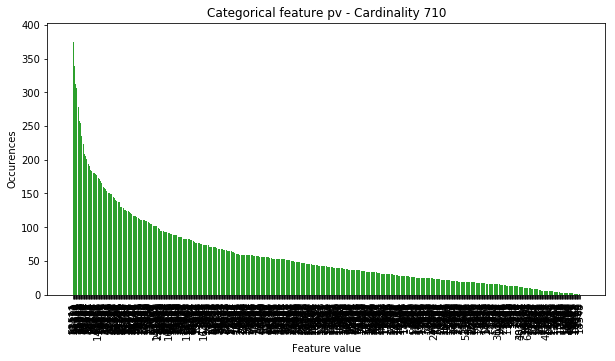

uv的特征分布如下：
4868    384
2554    374
2889    342
2187    339
5822    314
4009    313
2703    306
3500    305
2544    297
3035    278
5286    258
3065    255
7396    235
4005    227
2308    224
2957    221
5942    209
6647    206
2570    205
2048    201
4723    201
847     200
7616    199
7555    194
2999    194
4892    188
2942    185
1867    183
2654    181
3512    180
       ... 
221       5
2857      5
1378      5
1655      5
436       5
433       4
1595      4
993       4
273       4
290       4
230       3
1699      3
1257      3
189       3
117       3
101       3
551       2
934       2
697       2
1216      2
516       2
1149      2
825       2
203       1
933       1
754       1
744       1
428       1
651       1
79        1
Name: uv, Length: 650, dtype: int64


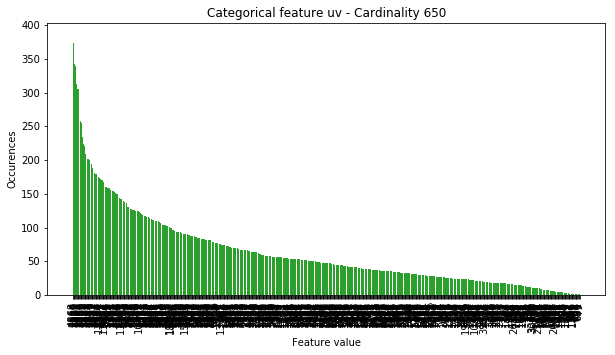

buildYear的特征分布如下：
单调特征： buildYear
1910       5
1912       3
1920       5
1926       2
1930      30
1931      11
1932      19
1936      12
1937       5
1939       2
1940       4
1949       4
1950       1
1951       1
1952      12
1953      75
1954     101
1955      20
1956     153
1957     227
1958     122
1959       3
1960      33
1961       2
1962       1
1963       4
1964      39
1965       8
1966      40
1967       7
        ... 
1988     423
1989     419
1990     431
1991     545
1992     308
1993    1543
1994    5659
1995    1685
1996     991
1997    1125
1998     733
1999     822
2000     925
2001     898
2002    1120
2003    1156
2004    1431
2005    1814
2006    2007
2007    1851
2008    1849
2009    1271
2010    1774
2011    1498
2012    1049
2013     714
2014    1238
2015     840
2016     140
2017      14
Name: buildYear, Length: 79, dtype: int64


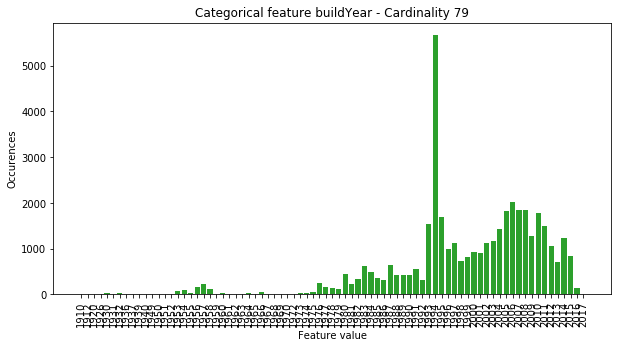

month的特征分布如下：
单调特征： month
1     1159
2     2321
3     7924
4     3800
5     3837
6     4121
7     3737
8     4086
9     3431
10    2836
11    2139
12    2049
Name: month, dtype: int64


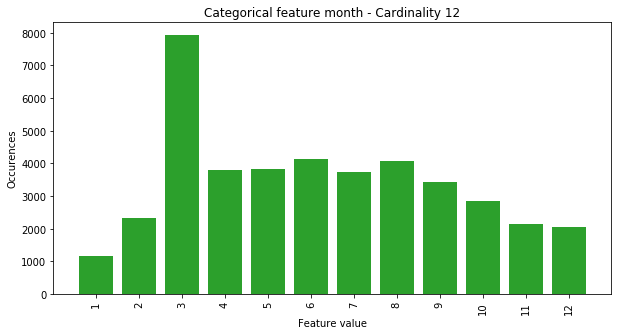

day的特征分布如下：
单调特征： day
1     1601
2     1414
3     1571
4     1519
5     1332
6     1254
7     1375
8     1456
9     1453
10    1557
11    1419
12    1241
13    1232
14    1242
15    1375
16    1251
17    1174
18    1352
19    1126
20    1225
21    1329
22    1263
23    1333
24    1518
25    1600
26    1428
27    1345
28    1406
29    1148
30    1134
31     767
Name: day, dtype: int64


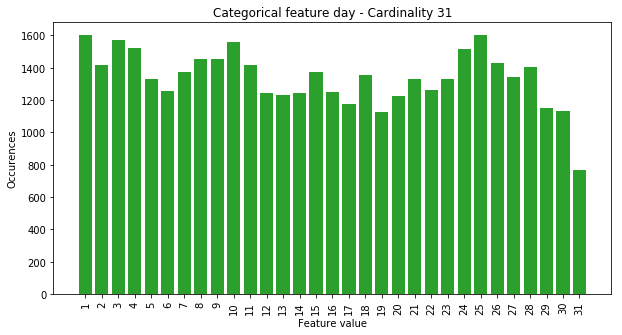

rentType的特征分布如下：
3    30759
2     5472
1     5204
0        5
Name: rentType, dtype: int64


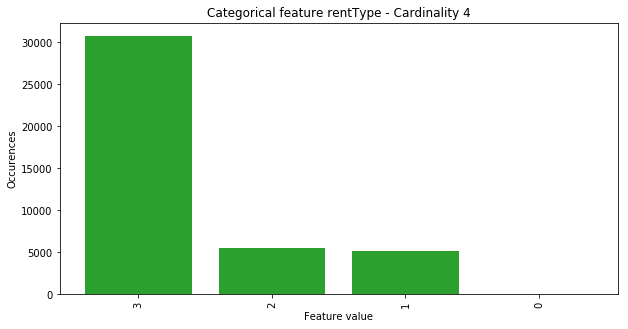

communityName的特征分布如下：
单调特征： communityName
0        1
1        2
2        1
3        3
4       13
5        2
6        2
7        1
8        4
9        3
10      10
11       3
12       3
13       1
14       5
15       6
16       3
17       1
18       7
19       1
20      14
21       6
22       1
23       2
24       2
25       2
26       1
27       1
28       2
29       1
        ..
4206    19
4207     2
4208     3
4209     2
4210     3
4211     3
4212     6
4213     2
4214     6
4215     3
4216     2
4217     2
4218     2
4219     5
4220     2
4221    10
4222     3
4223     1
4224     6
4225     2
4226     1
4227     9
4228    11
4229     6
4230     1
4231    13
4232     4
4233     3
4234     3
4235     1
Name: communityName, Length: 4236, dtype: int64


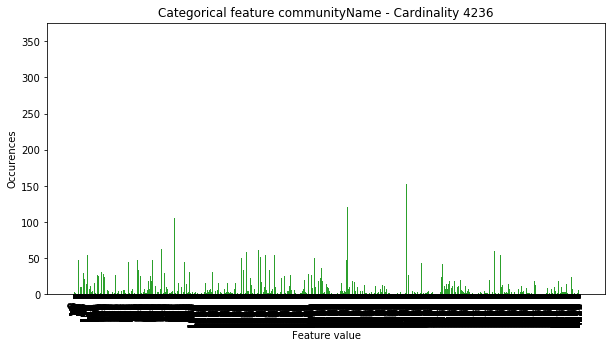

houseType的特征分布如下：
4      9805
12     8512
16     6783
24     3992
28     2737
39     1957
27     1920
2      1286
6       933
17      881
44      435
9       419
45      273
53      197
13      155
29      149
25      135
1        86
74       65
46       62
59       54
43       40
5        39
50       34
49       34
58       33
65       30
60       30
66       20
40       20
       ... 
35        1
56        1
98        1
88        1
89        1
72        1
99        1
97        1
92        1
62        1
96        1
31        1
87        1
23        1
55        1
73        1
100       1
52        1
37        1
69        1
101       1
20        1
81        1
102       1
80        1
14        1
75        1
103       1
42        1
0         1
Name: houseType, Length: 104, dtype: int64


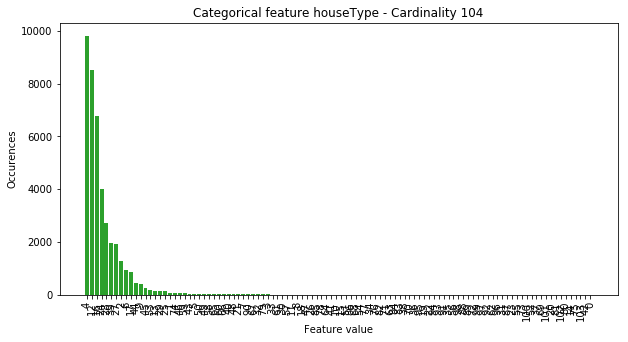

houseFloor的特征分布如下：
0    15458
2    14066
1    11916
Name: houseFloor, dtype: int64


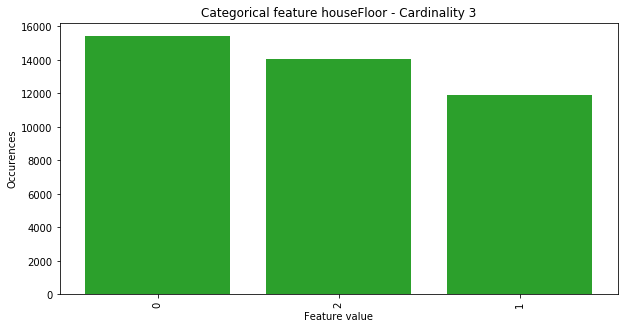

houseToward的特征分布如下：
4    34377
5     2254
3     2043
6      963
1      655
0      552
7      264
9      250
8       58
2       24
Name: houseToward, dtype: int64


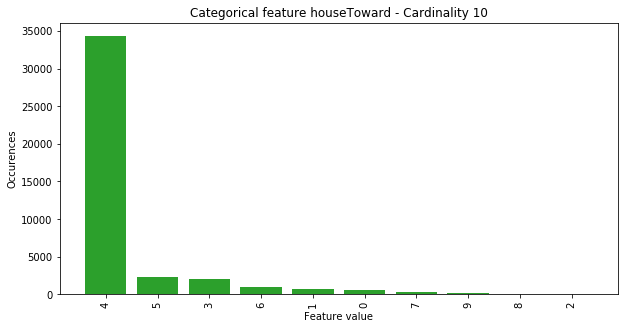

houseDecoration的特征分布如下：
0    29040
3    10918
2     1171
1      311
Name: houseDecoration, dtype: int64


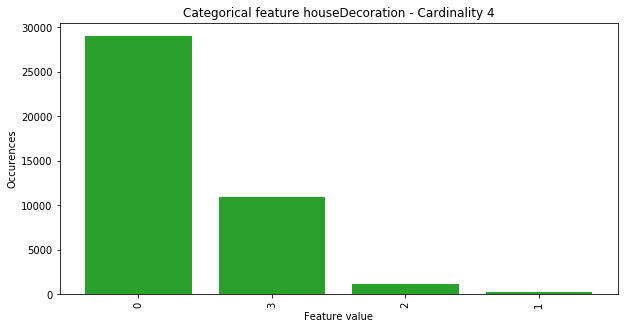

region的特征分布如下：
RG00002    11437
RG00005     5739
RG00003     4186
RG00010     3640
RG00012     3368
RG00004     3333
RG00006     1961
RG00007     1610
RG00008     1250
RG00013     1215
RG00001     1157
RG00014     1069
RG00011      793
RG00009      681
RG00015        1
Name: region, dtype: int64


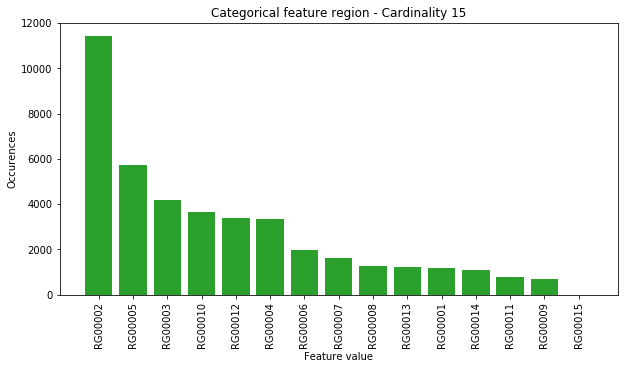

plate的特征分布如下：
30    1958
32    1837
44    1816
54    1566
55    1516
51    1375
16    1305
40    1266
53    1256
50    1253
45    1227
34    1156
41    1137
8     1016
49     979
42     930
25     906
46     880
33     849
12     834
52     819
27     745
39     679
59     671
9      651
28     646
61     618
21     614
17     613
63     590
      ... 
36     444
11     412
37     398
23     397
19     384
1      357
64     348
26     344
38     343
62     281
56     278
14     253
5      231
20     226
6      225
65     219
29     219
48     211
7      210
3      189
47     165
24     157
22     127
58     122
43      98
15      40
35      33
57      15
31       3
0        1
Name: plate, Length: 66, dtype: int64


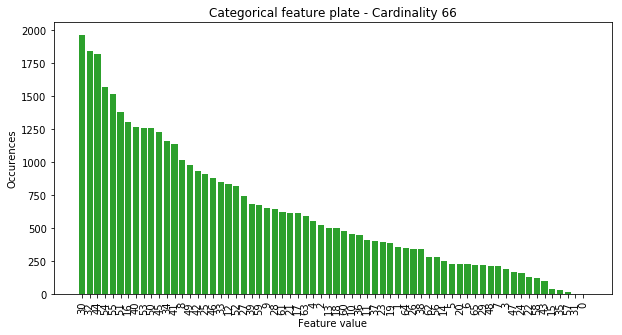

In [159]:

pal = sns.color_palette()
categorical_feas = ['pv', 'uv', 'buildYear', 'month', 'day', 'rentType','communityName','houseType', 'houseFloor', 'houseToward', 'houseDecoration',  'region', 'plate']
incresing_fea = ['area', 'communityName', 'buildYear', 'month','day', 'tradeMoney']
for feature in categorical_feas:
    print(feature + "的特征分布如下：")
    
    value_counts = train_data[feature].value_counts()

    if feature in incresing_fea:
        print('单调特征： '+feature)
        value_counts = value_counts.sort_index();    #对单调特征值进行排序
    print(value_counts)
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.title('Categorical feature {} - Cardinality {}'.format(feature, len(np.unique(train_data[feature]))))
    plt.xlabel('Feature value')
    plt.ylabel('Occurences')
    plt.bar(range(len(value_counts)), value_counts.values, color=pal[2])
    ax.set_xticks(range(len(value_counts)))
    ax.set_xticklabels(value_counts.index, rotation='vertical')
    plt.show()

## 二、异常值处理

## 主要思路分析
主要针对area和tradeMoney两个维度进行处理

针对tradeMoney 采用的是 Isolationforest模型进行自动处理

针对areahetotalFloor是主观+数据可视化的方式


In [160]:
def IF_drop(train):
    IForest = IsolationForest(contamination = 0.01)
    IForest.fit(train["tradeMoney"].values.reshape(-1, 1))
    y_pred = IForest.predict(train["tradeMoney"].values.reshape(-1,1))
    drop_index = train.loc[y_pred == -1].index
    print(drop_index)
    train.drop(drop_index, inplace = True)
    return train

train_data = IF_drop(train_data)

Int64Index([   62,    69,   128,   131,   246,   261,   266,   297,   308,
              313,
            ...
            39224, 39228, 39319, 39347, 39352, 39434, 39563, 41080, 41083,
            41233],
           dtype='int64', length=403)


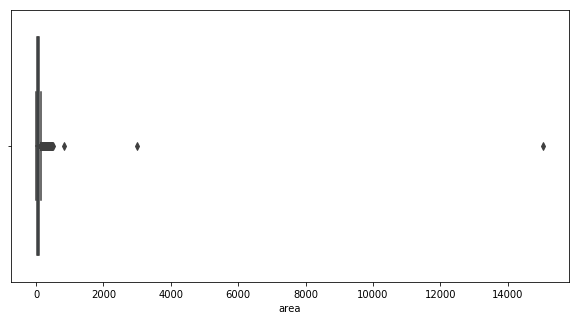

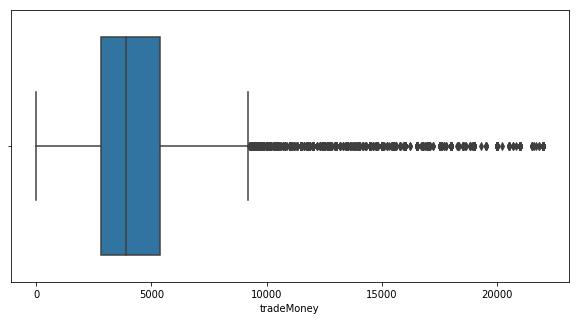

In [161]:
plt.figure(figsize=(10,5))
sns.boxplot(train_data.area)
plt.show()
plt.figure(figsize=(10,5))
sns.boxplot(train_data.tradeMoney),
plt.show()

In [162]:
def dropData(train):
    #舍弃异常值
    train = train[train.area <= 200]
    train = train[(train.tradeMoney <= 16000) & (train.tradeMoney >= 700)]
    train.drop(train[(train['totalFloor'] == 0)].index, inplace = True)
    return train

train_data = dropData(train_data)

In [163]:
train_data.info()
train_data.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40215 entries, 0 to 41439
Data columns (total 50 columns):
area                  40215 non-null float64
rentType              40215 non-null int32
houseType             40215 non-null int32
houseFloor            40215 non-null int32
totalFloor            40215 non-null int64
houseToward           40215 non-null int32
houseDecoration       40215 non-null int32
communityName         40215 non-null int32
region                40215 non-null object
plate                 40215 non-null int32
buildYear             40215 non-null int32
saleSecHouseNum       40215 non-null int64
subwayStationNum      40215 non-null int64
busStationNum         40215 non-null int64
interSchoolNum        40215 non-null int64
schoolNum             40215 non-null int64
privateSchoolNum      40215 non-null int64
hospitalNum           40215 non-null int64
drugStoreNum          40215 non-null int64
gymNum                40215 non-null int64
bankNum               40215 

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,region,plate,...,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeMoney,month,day
0,68.06,3,12,1,16,6,0,50,RG00001,63,...,0.0000,28248,614,111546,1124,284,0,2000.0,11,28
1,125.55,3,28,0,14,6,2,129,RG00002,48,...,0.0000,14823,148,157552,701,22,1,2000.0,12,16
2,132.00,3,28,1,32,6,0,178,RG00002,49,...,0.0000,77645,520,131744,57,20,1,16000.0,12,22
3,57.00,3,4,0,17,6,3,312,RG00002,50,...,3080.0331,8750,1665,253337,888,279,9,1600.0,12,21
4,129.00,3,29,1,2,6,1,1256,RG00003,43,...,0.0000,800,117,125309,2038,480,0,2900.0,11,18
6,78.94,3,16,0,18,6,0,245,RG00002,50,...,0.0000,8750,1467,253337,1586,469,0,1000.0,11,18
7,76.00,3,12,0,5,6,0,2330,RG00006,30,...,0.0000,28546,0,371900,40787,2942,0,1800.0,3,24
8,120.55,3,27,0,6,6,0,2345,RG00006,30,...,0.0000,28546,0,371900,40787,2942,0,1450.0,3,19
9,83.00,3,24,0,5,6,0,2309,RG00006,30,...,0.0000,28546,0,371900,34441,3035,0,1700.0,4,26
10,89.00,3,12,0,6,6,0,2331,RG00006,30,...,0.0000,28546,0,371900,34441,3035,0,1500.0,4,29


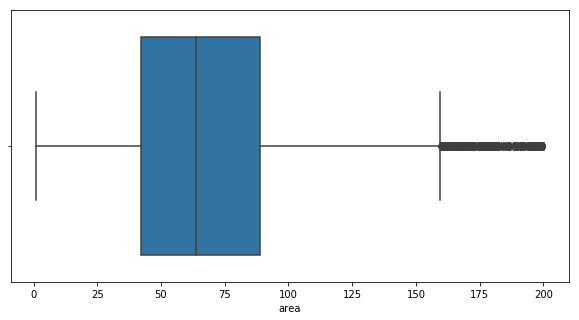

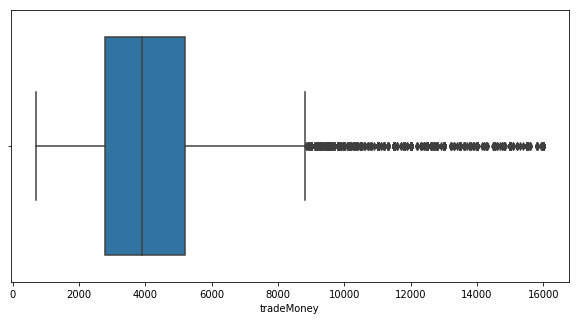

In [164]:
# 去除异常值之后的area和tradeMoney箱线图
plt.figure(figsize=(10,5))
sns.boxplot(train_data.area)
plt.show()
plt.figure(figsize=(10,5))
sns.boxplot(train_data.tradeMoney),
plt.show()

count    40215.000000
mean        66.162832
std         35.135548
min          1.000000
25%         42.000000
50%         63.650000
75%         89.000000
max        200.000000
Name: area, dtype: float64


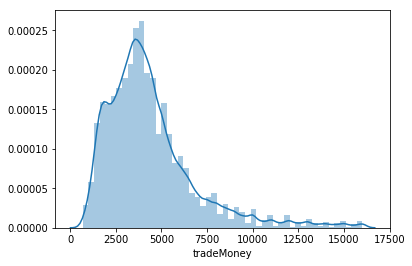

In [165]:
#去除异常值之后的Label分布
print(train_data.area.describe())
sns.distplot(train_data['tradeMoney'])

count    40215.000000
mean      4383.848564
std       2500.351042
min        700.000000
25%       2790.000000
50%       3900.000000
75%       5200.000000
max      16000.000000
Name: tradeMoney, dtype: float64


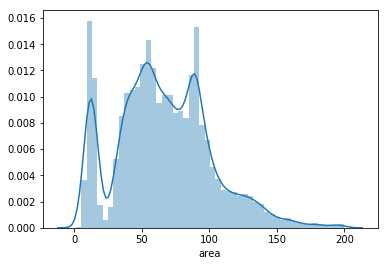

In [166]:
# 去除异常值之后的area分布
print(train_data.tradeMoney.describe())
sns.distplot(train_data['area'])

## 深度清洗

## 主要思路分析
针对每一个region的数据，对area和tradeMoney两个维度进行深度清洗。

In [167]:
print(train_data.region.describe())
print(train_data.region.value_counts())

count       40215
unique         15
top       RG00002
freq        11039
Name: region, dtype: object
RG00002    11039
RG00005     5542
RG00003     4066
RG00010     3590
RG00012     3351
RG00004     3300
RG00006     1941
RG00007     1591
RG00008     1212
RG00001     1134
RG00013     1067
RG00014     1041
RG00011      691
RG00009      649
RG00015        1
Name: region, dtype: int64


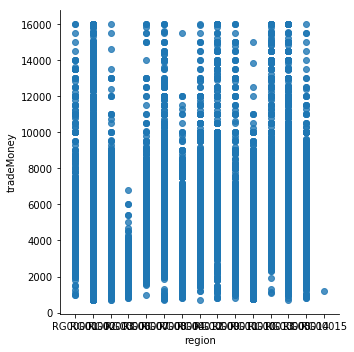

In [168]:
#输出region和tradeMoney的散点图
df = train_data
sns.lmplot(x = 'region', y = 'tradeMoney', data = df, fit_reg=False)

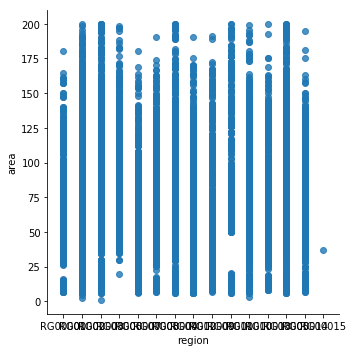

In [169]:
#输出region和area的散点图
sns.lmplot(x = 'region', y = 'area', data = df, fit_reg=False)

RG00002    11039
RG00005     5542
RG00003     4066
RG00010     3590
RG00012     3351
RG00004     3300
RG00006     1941
RG00007     1591
RG00008     1212
RG00001     1134
RG00013     1067
RG00014     1041
RG00011      691
RG00009      649
RG00015        1
Name: region, dtype: int64


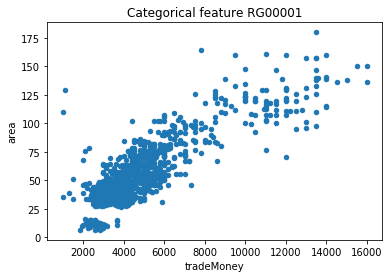

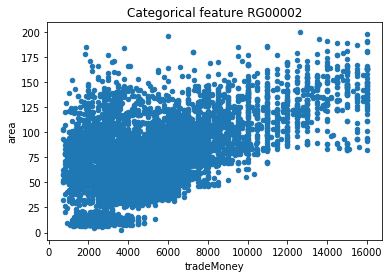

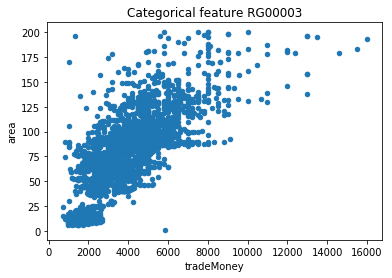

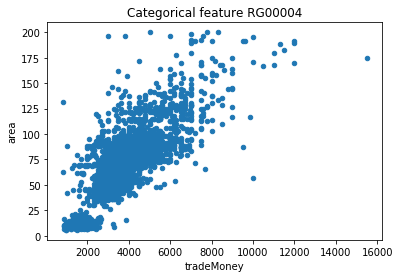

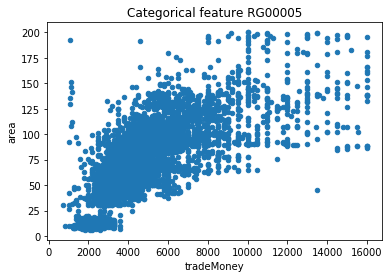

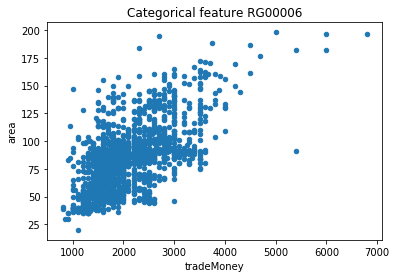

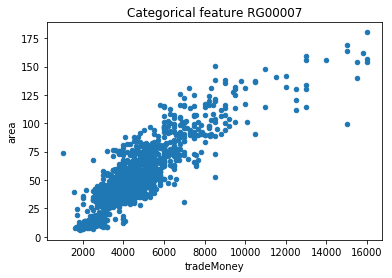

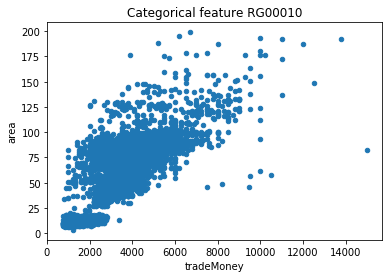

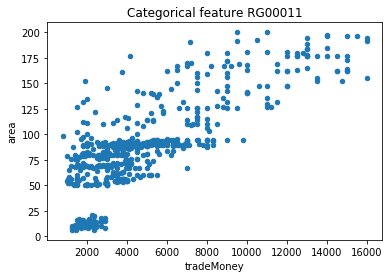

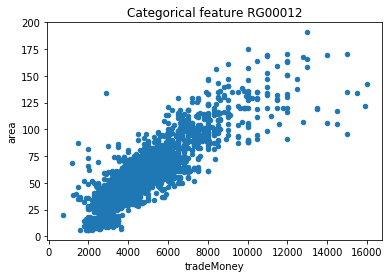

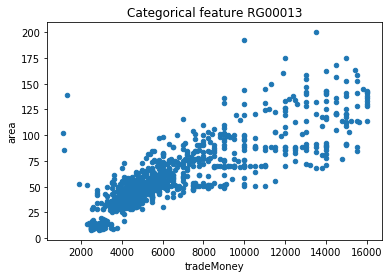

In [175]:
#输出以下region的tradeMoney和area分布
region_feas = ['RG00001', 'RG00002', 'RG00003', 'RG00004', 'RG00005', 'RG00006', 'RG00007', 'RG00010', 'RG00011', 'RG00012', 'RG00013']
print(train_data.region.value_counts())
for fea in region_feas:
    train_data[(train_data['region']==fea)].plot(kind = 'scatter', x = 'tradeMoney', y = 'area')
    plt.title('Categorical feature {}'.format(fea))

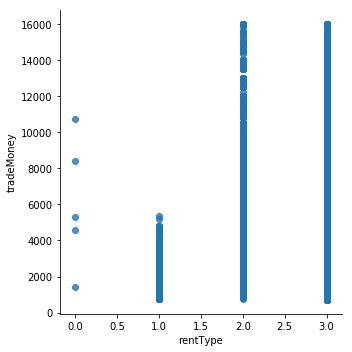

In [177]:
df = train_data[['rentType', 'tradeMoney']]
sns.lmplot(x='rentType', y = 'tradeMoney', data = df, fit_reg=False)

In [178]:
#玄学...
def cleanData(data):
    data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']<1000)&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']>25000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>250)&(data['tradeMoney']<20000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>400)&(data['tradeMoney']>50000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>100)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00002') & (data['area']<100)&(data['tradeMoney']>60000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['area']<300)&(data['tradeMoney']>30000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<500)&(data['area']<50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<1500)&(data['area']>100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<2000)&(data['area']>300)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']>5000)&(data['area']<20)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['area']>600)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['tradeMoney']<1000)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']<2000)&(data['area']>180)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>50000)&(data['area']<200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['area']>200)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00007') & (data['area']>100)&(data['tradeMoney']<2500)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['area']>200)&(data['tradeMoney']>25000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['area']>400)&(data['tradeMoney']<15000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']<3000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']>7000)&(data['area']<75)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']>12500)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['area']>400)&(data['tradeMoney']>20000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008') & (data['tradeMoney']<2000)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['area']>300)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['area']>100)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00011') & (data['tradeMoney']<10000)&(data['area']>390)].index,inplace=True)
    data.drop(data[(data['region']=='RG00012') & (data['area']>120)&(data['tradeMoney']<5000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']<100)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']>400)&(data['tradeMoney']>50000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']>80)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['area']>300)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<1300)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<8000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<1000)&(data['area']>20)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']>25000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<20000)&(data['area']>250)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>30000)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']<50000)&(data['area']>600)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>50000)&(data['area']>350)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']>4000)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<600)&(data['area']>100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['area']>165)].index,inplace=True)
    data.drop(data[(data['region']=='RG00012') & (data['tradeMoney']<800)&(data['area']<30)].index,inplace=True)
    data.drop(data[(data['region']=='RG00007') & (data['tradeMoney']<1100)&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['tradeMoney']>8000)&(data['area']<80)].index,inplace=True)
    data.loc[(data['region']=='RG00002')&(data['area']>50)&(data['rentType']=='合租'),'rentType']='整租'
    data.loc[(data['region']=='RG00014')&(data['rentType']=='合租')&(data['area']>60),'rentType']='整租'
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']>15000)&(data['area']<110)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']>20000)&(data['area']>110)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']<1500)&(data['area']<50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['rentType']=='合租')&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00015') ].index,inplace=True)
    data.reset_index(drop=True, inplace=True)
    return data

data_train = cleanData(data_train)

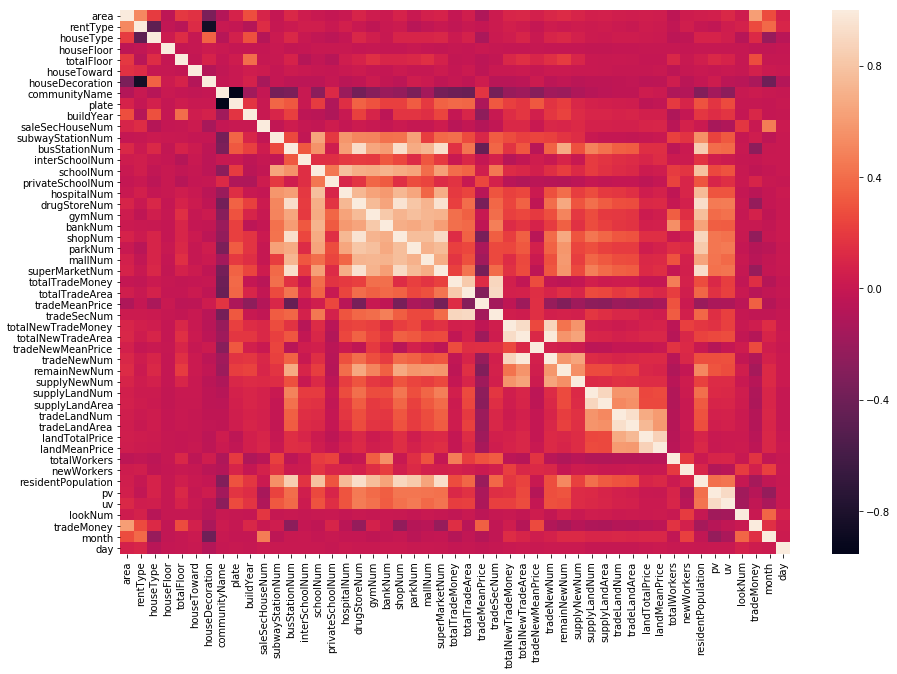

In [179]:
# 热力图，查看特征相关性
corr = train_data.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr)

RG00002    11039
RG00005     5542
RG00003     4066
RG00010     3590
RG00012     3351
RG00004     3300
RG00006     1941
RG00007     1591
RG00008     1212
RG00001     1134
RG00013     1067
RG00014     1041
RG00011      691
RG00009      649
RG00015        1
Name: region, dtype: int64


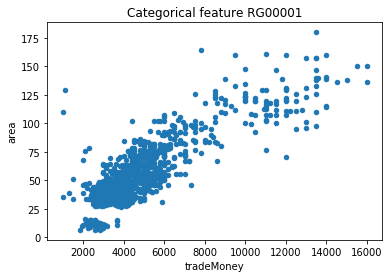

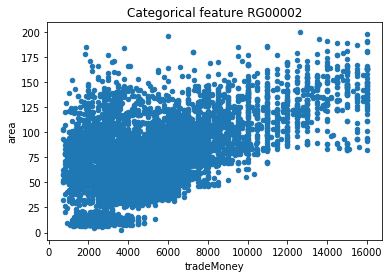

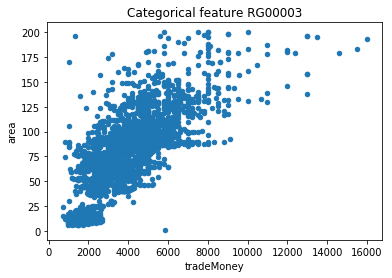

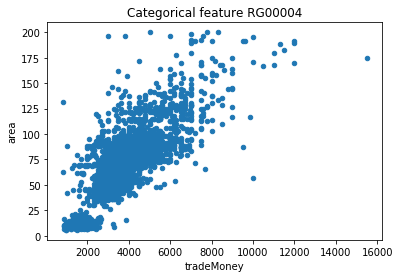

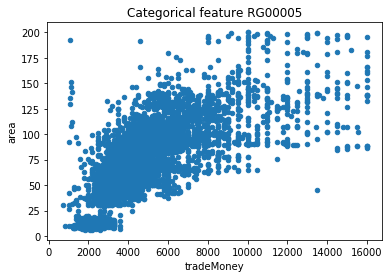

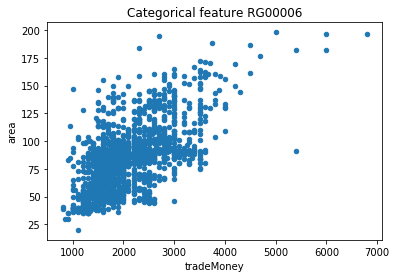

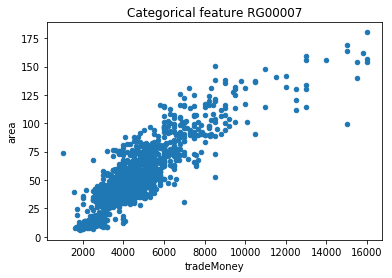

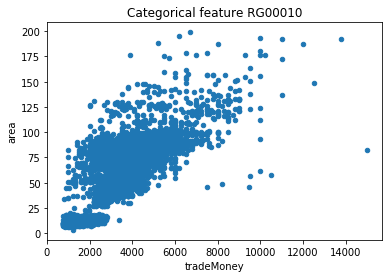

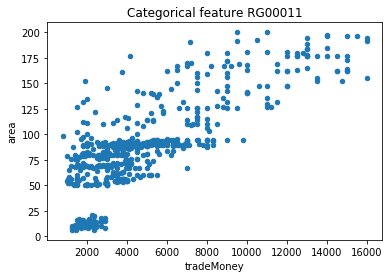

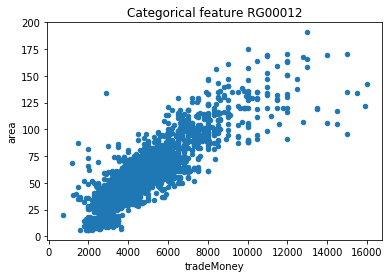

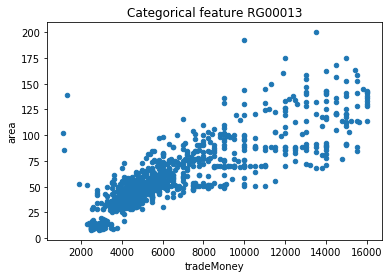

In [180]:
#清洗之后的tradeMoney， area分布
region_feas = ['RG00001', 'RG00002', 'RG00003', 'RG00004', 'RG00005', 'RG00006', 'RG00007', 'RG00010', 'RG00011', 'RG00012', 'RG00013']
print(train_data.region.value_counts())
for fea in region_feas:
    train_data[(train_data['region']==fea)].plot(kind = 'scatter', x = 'tradeMoney', y = 'area')
    plt.title('Categorical feature {}'.format(fea))

In [181]:
print(train_data.describe())
train_data.head(10)

               area      rentType     houseType    houseFloor    totalFloor  \
count  40215.000000  40215.000000  40215.000000  40215.000000  40215.000000   
mean      66.162832      2.610842     15.459207      0.965585     11.276862   
std       35.135548      0.704864     11.172760      0.847975      7.017593   
min        1.000000      0.000000      1.000000      0.000000      1.000000   
25%       42.000000      2.000000      4.000000      0.000000      6.000000   
50%       63.650000      3.000000     12.000000      1.000000      7.000000   
75%       89.000000      3.000000     24.000000      2.000000     16.000000   
max      200.000000      3.000000     97.000000      2.000000     56.000000   

        houseToward  houseDecoration  communityName         plate  \
count  40215.000000     40215.000000   40215.000000  40215.000000   
mean       3.990576         0.854557    1955.850205     35.639612   
std        0.854243         1.327490    1162.228407     16.861763   
min        0

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,region,plate,...,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeMoney,month,day
0,68.06,3,12,1,16,6,0,50,RG00001,63,...,0.0000,28248,614,111546,1124,284,0,2000.0,11,28
1,125.55,3,28,0,14,6,2,129,RG00002,48,...,0.0000,14823,148,157552,701,22,1,2000.0,12,16
2,132.00,3,28,1,32,6,0,178,RG00002,49,...,0.0000,77645,520,131744,57,20,1,16000.0,12,22
3,57.00,3,4,0,17,6,3,312,RG00002,50,...,3080.0331,8750,1665,253337,888,279,9,1600.0,12,21
4,129.00,3,29,1,2,6,1,1256,RG00003,43,...,0.0000,800,117,125309,2038,480,0,2900.0,11,18
6,78.94,3,16,0,18,6,0,245,RG00002,50,...,0.0000,8750,1467,253337,1586,469,0,1000.0,11,18
7,76.00,3,12,0,5,6,0,2330,RG00006,30,...,0.0000,28546,0,371900,40787,2942,0,1800.0,3,24
8,120.55,3,27,0,6,6,0,2345,RG00006,30,...,0.0000,28546,0,371900,40787,2942,0,1450.0,3,19
9,83.00,3,24,0,5,6,0,2309,RG00006,30,...,0.0000,28546,0,371900,34441,3035,0,1700.0,4,26
10,89.00,3,12,0,6,6,0,2331,RG00006,30,...,0.0000,28546,0,371900,34441,3035,0,1500.0,4,29
